In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.ndimage.filters import uniform_filter1d
from matplotlib.gridspec import GridSpec
import geopandas as gpd
import regionmask

from glob import glob
from cartopy.util import add_cyclic_point
from scipy.stats import ttest_rel

from scipy.stats import linregress
import statsmodels.api as sm

## Temp vs Precip vs FAC

In [ ]:
shelf_mask_da = xr.open_dataarray('masks/era/shelf_mask.nc')
el_mask_da = xr.open_dataarray('masks/era/low_elevation.nc')
area_da = xr.open_dataarray('masks/era/area.nc')

In [8]:
files = glob('model_median*.nc')

if len(files)==0:

    ssp1_data_fac = xr.open_dataset(f'netcdf_results/emulator_FAC/ssp1_fac_{run}.nc')
    ssp3_data_fac = xr.open_dataset(f'netcdf_results/emulator_FAC/ssp3_fac_{run}.nc')
    ssp5_data_fac = xr.open_dataset(f'netcdf_results/emulator_FAC/ssp5_fac_{run}.nc')
    hist_data_fac = xr.open_dataset(f'netcdf_results/emulator_FAC/era_{run}.nc')

    model_ssp3_fac = ssp3_data_fac.fac.quantile(0.5, dim='model')*shelf_mask
    model_ssp5_fac = ssp5_data_fac.fac.quantile(0.5, dim='model')*shelf_mask

    model_ssp3_fac.to_netcdf('model_median_ssp3_fac.nc')
    model_ssp5_fac.to_netcdf('model_median_ssp5_fac.nc')
    
else:
    model_ssp3_fac = xr.open_dataset('model_median_ssp3_fac.nc')
    model_ssp5_fac = xr.open_dataset('model_median_ssp5_fac.nc')


In [ ]:
ssp1_data_climate = xr.open_dataset(f'netcdf_results/emulator_results/ssp1_fac_{run}.nc')
ssp3_data_climate = xr.open_dataset(f'netcdf_results/emulator_results/ssp3_fac_{run}.nc')
ssp5_data_climate = xr.open_dataset(f'netcdf_results/emulator_results/ssp5_fac_{run}.nc')
hist_data_climate = xr.open_dataset(f'netcdf_results/emulator_results/era_{run}.nc')

model_ssp3_pr = ssp3_data_climate.pr.mean(dim='model')*shelf_mask
model_ssp5_pr = ssp5_data_climate.pr.mean(dim='model')*shelf_mask

model_ssp3_tas = ssp3_data_climate.ta_s.mean(dim='model')*shelf_mask
model_ssp5_tas = ssp5_data_climate.ta_s.mean(dim='model')*shelf_mask

In [9]:
shelf_mask = (shelf_mask_da*el_mask_da).values
shelf_mask[~np.isnan(shelf_mask)]=1

In [14]:
model_ssp3_fac_np = model_ssp3_fac.values
model_ssp3_fac_nonan = model_ssp3_fac_np[np.logical_not(np.isnan(model_ssp3_fac_np))]

model_ssp5_fac_np = model_ssp5_fac.values
model_ssp5_fac_nonan = model_ssp5_fac_np[np.logical_not(np.isnan(model_ssp5_fac_np))]

model_ssp3_tas_np = model_ssp3_tas.values
model_ssp3_tas_nonan = model_ssp3_tas_np[np.logical_not(np.isnan(model_ssp3_tas_np))]

model_ssp5_tas_np = model_ssp5_tas.values
model_ssp5_tas_nonan = model_ssp5_tas_np[np.logical_not(np.isnan(model_ssp5_tas_np))]

model_ssp3_pr_np = model_ssp3_pr.values
model_ssp3_pr_nonan = model_ssp3_pr_np[np.logical_not(np.isnan(model_ssp3_pr_np))]

model_ssp5_pr_np = model_ssp5_pr.values
model_ssp5_pr_nonan = model_ssp5_pr_np[np.logical_not(np.isnan(model_ssp5_pr_np))]


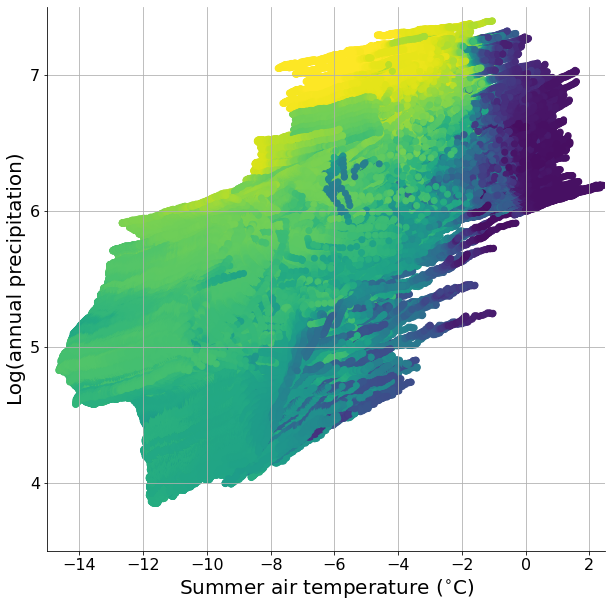

In [16]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.scatter(model_ssp5_tas_nonan, np.log(model_ssp5_pr_nonan), c = model_ssp5_fac_nonan, vmin = 0, vmax = 25)
#ax.plot(x,y,color = 'lightgrey', linewidth = 2, linestyle = 'dashed')

im = ax.scatter(model_ssp3_tas_nonan, np.log(model_ssp3_pr_nonan), c = model_ssp5_fac_nonan, vmin = 0, vmax = 25)

ax.tick_params(which='both', labelsize = 16)
ax.set_xlabel('Summer air temperature ($^{\circ}$C)', fontsize = 20)
ax.set_ylabel('Log(annual precipitation)', fontsize = 20)
ax.set_xlim([-15, 2.5])
ax.set_ylim([3, 8])

# cb = plt.colorbar(im, extend = 'both')
# cb.set_label('FAC (m)', fontsize = 18)
# cb.ax.tick_params(labelsize=14)
ax.set_xlim([-15, 2.5])
ax.set_ylim([3.5, 7.5])
ax.set_yticks([4,5,6,7])
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.savefig('temp_precip_FAC_all.png', dpi = 300, bbox_inches = 'tight', transparent = True)
# #plt.scatter(model_ssp1_tas_nonan, model_ssp1_pr_nonan, c = model_ssp5_fac_nonan, vmin = 0, vmax = 25, cmap = 'inferno')

In [57]:
def get_shelf_mask(area_num):

    if area_num == 'ross':
        mask = shelf_mask_da.where((shelf_mask_da==69)|(shelf_mask_da==70))
    elif area_num == 'rf':#ronne-filchner
        mask = shelf_mask_da.where((shelf_mask_da==33)|(shelf_mask_da==34))
    else: mask = shelf_mask_da.where(shelf_mask_da==area_num)     
        
    mask2 = mask.dropna(dim = 'lon', how='all')
    mask2 = mask2.dropna(dim = 'lat', how='all')
    mask_lat = mask2.lat.values
    mask_lon = mask2.lon.values
    
    return mask, mask_lat, mask_lon

def clip_data_to_mask(area):
    mask, mask_lat, mask_lon= get_shelf_mask(area)

    mask_np = mask.sel(lat = slice(np.max(mask_lat), np.min(mask_lat)), lon = slice(np.min(mask_lon), np.max(mask_lon))).values
    mask_np[~np.isnan(mask_np)]=1
    
    low_el_mask = el_mask_da.sel(lat = slice(np.max(mask_lat), np.min(mask_lat)), lon = slice(np.min(mask_lon), np.max(mask_lon))).values
    
    era_area = area_da.sel(lat = slice(np.max(mask_lat), np.min(mask_lat)), lon = slice(np.min(mask_lon), np.max(mask_lon)))
    shelf_area = (mask_np*era_area*low_el_mask).sum(dim = ['lat','lon'])

    clipped_ssp5 = ssp5_data_climate.sel(lat = slice(np.max(mask_lat), np.min(mask_lat)), lon = slice(np.min(mask_lon), np.max(mask_lon)))
    ssp5_ts = (clipped_ssp5*mask*era_area*low_el_mask).sum(dim = ['lat','lon'])/shelf_area
    
    clipped_ssp3 = ssp3_data_climate.sel(lat = slice(np.max(mask_lat), np.min(mask_lat)), lon = slice(np.min(mask_lon), np.max(mask_lon)))
    ssp3_ts = (clipped_ssp3*mask*era_area*low_el_mask).sum(dim = ['lat','lon'])/shelf_area
    
    clipped_ssp1 = ssp1_data_climate.sel(lat = slice(np.max(mask_lat), np.min(mask_lat)), lon = slice(np.min(mask_lon), np.max(mask_lon)))
    ssp1_ts = (clipped_ssp1*mask*era_area*low_el_mask).sum(dim = ['lat','lon'])/shelf_area
    
    return ssp5_ts.mean(dim = 'model'), ssp3_ts.mean(dim = 'model'), ssp1_ts.mean(dim = 'model')


In [59]:
RBIS5, RBIS3, RBIS1 = clip_data_to_mask(117)
RF5, RF3, RF1 = clip_data_to_mask('rf')
Ross5, Ross3, Ross1 = clip_data_to_mask('ross')
LC5, LC3, LC1 = clip_data_to_mask(7)
th5, th3, th1 = clip_data_to_mask(55)
wi5, wi3, wi1 = clip_data_to_mask(49)
am5, am3, am1 = clip_data_to_mask(114)
# #Fimbul = clip_data_to_mask(120)

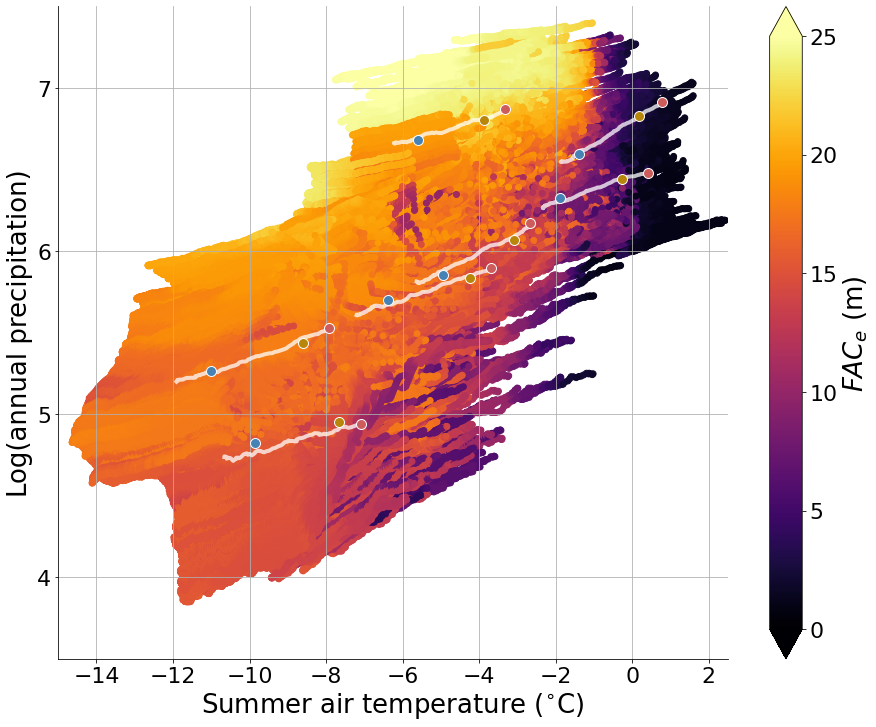

In [63]:
fig, ax = plt.subplots(1,1,figsize = (15,12))
ax.scatter(model_ssp5_tas_nonan, np.log(model_ssp5_pr_nonan), c = model_ssp5_fac_nonan, vmin = 0, vmax = 25, cmap = 'inferno')
im = ax.scatter(model_ssp3_tas_nonan, np.log(model_ssp3_pr_nonan), c = model_ssp3_fac_nonan, vmin = 0, vmax = 25, cmap = 'inferno')

ax.tick_params(which='both', labelsize = 22)
ax.set_xlabel('Summer air temperature ($^{\circ}$C)', fontsize = 26)
ax.set_ylabel('Log(annual precipitation)', fontsize = 26)
ax.set_xlim([-15, 2.5])
ax.set_ylim([3.5, 7.5])
ax.set_yticks([4,5,6,7])
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


cb = plt.colorbar(im, extend = 'both')
cb.set_label('$FAC_e$ (m)', fontsize = 26)
cb.ax.tick_params(labelsize=22)

plt.plot(RBIS5.ta_s, np.log(RBIS5.pr), color = 'white', linewidth = 4, alpha = 0.75)
plt.plot(RF5.ta_s, np.log(RF5.pr), color = 'white', linewidth = 4, alpha = 0.75)
plt.plot(Ross5.ta_s, np.log(Ross5.pr), color = 'white', linewidth = 4, alpha = 0.75)
plt.plot(LC5.ta_s, np.log(LC5.pr), color = 'white', linewidth = 4, alpha = 0.75)
plt.plot(th5.ta_s, np.log(th5.pr), color = 'white', linewidth = 4, alpha = 0.75)
plt.plot(wi5.ta_s, np.log(wi5.pr), color = 'white', linewidth = 4, alpha = 0.75)
plt.plot(am5.ta_s, np.log(am5.pr), color = 'white', linewidth = 4, alpha = 0.75)

plt.plot(RBIS3.ta_s.isel(year = -1), np.log(RBIS3.pr).isel(year = -1), 'o',color = 'darkgoldenrod', markersize = 10, markeredgecolor = 'white')
plt.plot(RF3.ta_s.isel(year = -1), np.log(RF3.pr).isel(year = -1), 'o',color = 'darkgoldenrod', markersize = 10, markeredgecolor = 'white')
plt.plot(Ross3.ta_s.isel(year = -1), np.log(Ross3.pr).isel(year = -1), 'o',color = 'darkgoldenrod', markersize = 10, markeredgecolor = 'white')
plt.plot(LC3.ta_s.isel(year = -1), np.log(LC3.pr).isel(year = -1), 'o',color = 'darkgoldenrod', markersize = 10, markeredgecolor = 'white')
plt.plot(th3.ta_s.isel(year = -1), np.log(th3.pr).isel(year = -1), 'o',color = 'darkgoldenrod', markersize = 10, markeredgecolor = 'white')
plt.plot(wi3.ta_s.isel(year = -1), np.log(wi3.pr).isel(year = -1), 'o',color = 'darkgoldenrod', markersize = 10, markeredgecolor = 'white')
plt.plot(am3.ta_s.isel(year = -1), np.log(am3.pr).isel(year = -1), 'o',color = 'darkgoldenrod', markersize = 10, markeredgecolor = 'white')

plt.plot(RBIS5.ta_s.isel(year = -1), np.log(RBIS5.pr).isel(year = -1), 'o',color = 'indianred', markersize = 10, markeredgecolor = 'white')
plt.plot(RF5.ta_s.isel(year = -1), np.log(RF5.pr).isel(year = -1), 'o',color = 'indianred', markersize = 10, markeredgecolor = 'white')
plt.plot(Ross5.ta_s.isel(year = -1), np.log(Ross5.pr).isel(year = -1), 'o',color = 'indianred', markersize = 10, markeredgecolor = 'white')
plt.plot(LC5.ta_s.isel(year = -1), np.log(LC5.pr).isel(year = -1), 'o',color = 'indianred', markersize = 10, markeredgecolor = 'white')
plt.plot(th5.ta_s.isel(year = -1), np.log(th5.pr).isel(year = -1), 'o',color = 'indianred', markersize = 10, markeredgecolor = 'white')
plt.plot(wi5.ta_s.isel(year = -1), np.log(wi5.pr).isel(year = -1), 'o',color = 'indianred', markersize = 10, markeredgecolor = 'white')
plt.plot(am5.ta_s.isel(year = -1), np.log(am5.pr).isel(year = -1), 'o',color = 'indianred', markersize = 10, markeredgecolor = 'white')

plt.plot(RBIS1.ta_s.isel(year = -1), np.log(RBIS1.pr).isel(year = -1), 'o',color = 'steelblue', markersize = 10, markeredgecolor = 'white')
plt.plot(RF1.ta_s.isel(year = -1), np.log(RF1.pr).isel(year = -1), 'o',color = 'steelblue', markersize = 10, markeredgecolor = 'white')
plt.plot(Ross1.ta_s.isel(year = -1), np.log(Ross1.pr).isel(year = -1), 'o',color = 'steelblue', markersize = 10, markeredgecolor = 'white')
plt.plot(LC1.ta_s.isel(year = -1), np.log(LC1.pr).isel(year = -1), 'o',color = 'steelblue', markersize = 10, markeredgecolor = 'white')
plt.plot(th1.ta_s.isel(year = -1), np.log(th1.pr).isel(year = -1), 'o',color = 'steelblue', markersize = 10, markeredgecolor = 'white')
plt.plot(wi1.ta_s.isel(year = -1), np.log(wi1.pr).isel(year = -1), 'o',color = 'steelblue', markersize = 10, markeredgecolor = 'white')
plt.plot(am1.ta_s.isel(year = -1), np.log(am1.pr).isel(year = -1), 'o',color = 'steelblue', markersize = 10, markeredgecolor = 'white')


plt.savefig('temp_precip_fac.png', dpi=300, transparent=True, bbox_inches = 'tight')